<a href="https://colab.research.google.com/github/NathanielGetachew/NathanielGetachew/blob/main/Bayesian_Hill_Climbing_with_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Bayesian-Inspired Hill Climbing using Graph Theory
This notebook demonstrates how to solve a quadratic equation using hill climbing, integrating principles from Bayesian inference and graph theory.

We model the hill climbing trajectory as a graph, where nodes represent guesses (x-values), and edges represent probabilistic transitions influenced by fitness (likelihood of correctness).

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from collections import defaultdict

from collections import Counter



## 🎯 Define the Quadratic Function and Fitness
- `f(x) = x**2 - 4*x + 3` has a root at 1.
- Fitness is the negative absolute value of f(x) to guide us toward the root.

In [15]:
def f(x):
    """The function whose root we're trying to find."""
    return x**2 - 4*x + 3  # Roots at x = 1 and x = 3

def fitness(x):
    """Fitness function: higher when closer to root (f(x) close to 0)."""
    return -abs(f(x))




## 🔄 Hill Climbing with Embedded Graph Structure
- Nodes are guesses (x-values).
- Edges represent transitions with bayesian probabilities.

In [16]:
def bayesian_update(prior_beliefs, likelihood):
    """Simple Bayesian belief update."""
    posterior = {}
    total = 0.0
    for x in likelihood:
        posterior[x] = prior_beliefs.get(x, 1e-6) * likelihood[x]
        total += posterior[x]
    # Normalize
    for x in posterior:
        posterior[x] /= (total + 1e-8)
    return posterior

def graph_hill_climb_with_bayes(start_value=-5.0, max_steps=100, step_size=0.1, neighbor_range=2.0, tolerance=1e-5):
    history = []
    current_x = round(start_value, 2)
    beliefs = defaultdict(lambda: 1e-5)
    beliefs[current_x] = 1.0

    G = nx.DiGraph()
    G.add_node(current_x)
    path = [current_x]
    node_fitness = {current_x: fitness(current_x)}

    for step in range(max_steps):
        current_fitness = fitness(current_x)

        # Generate neighbors
        neighbors = np.arange(current_x - neighbor_range, current_x + neighbor_range, step_size)
        neighbors = [round(n, 2) for n in neighbors]

        # Update beliefs
        likelihood = {n: 1.0 / (abs(f(n)) + 1e-6) for n in neighbors}
        beliefs = bayesian_update(beliefs, likelihood)

        # Pick based on belief and fitness
        best_belief_x = max(beliefs, key=beliefs.get)
        best_fitness_x = max(neighbors, key=fitness)

        best_belief_x = round(best_belief_x, 2)
        best_fitness_x = round(best_fitness_x, 2)

        history.append((current_x, current_fitness))

        # If Bayesian suggestion differs, show it as a dashed edge
        if best_belief_x != best_fitness_x:
            G.add_edge(current_x, best_belief_x, weight=0, bayesian=True)

        if fitness(best_fitness_x) > current_fitness:
            G.add_edge(current_x, best_fitness_x, weight=fitness(best_fitness_x) - current_fitness, bayesian=False)
            current_x = best_fitness_x
            node_fitness[current_x] = fitness(current_x)
            path.append(current_x)
        else:
            break

        if abs(current_fitness - fitness(best_fitness_x)) < tolerance:
            break

    best_x_found = round(current_x, 2)
    return history, G, best_x_found, beliefs, path


## 🧪 Run the Algorithm :## 📊 Visualize Transition Graph with Probabilities

In [27]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_graph(G, path, beliefs, best_x):
    pos = nx.spring_layout(G, seed=42)

    # Normalize beliefs with optional gamma correction
    belief_values = np.array([beliefs.get(n, 1e-6) for n in G.nodes()])
    belief_values = belief_values ** 0.3  # Gamma scaling for contrast
    belief_values = (belief_values - belief_values.min()) / (belief_values.max() - belief_values.min() + 1e-8)

    node_colors = plt.cm.viridis(belief_values)
    node_sizes = [800 if n == best_x else 600 for n in G.nodes()]

    fig, ax = plt.subplots(figsize=(10, 7))

    # Draw all edges (default gray)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), ax=ax, style='dashed', edge_color='gray')

    # Highlight path edges in red
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, ax=ax, width=2.5, edge_color='red')

    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax, edgecolors='black', linewidths=1.5)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=belief_values.min(), vmax=belief_values.max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Normalized Belief", fontsize=12)

    # Add node labels (x-values)
    labels = {n: f"{n:.1f}" for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_color='white', font_weight='bold', ax=ax)

    # Annotate path steps
    for i, node in enumerate(path):
        x, y = pos[node]
        offset = 0.1 if i == 0 else -0.15
        color = 'green' if i == 0 else 'black'
        text = "Start" if i == 0 else f"Step {i}"
        plt.text(x, y + offset, text, fontsize=10, color=color, ha='center')

    # Mark true root
    root_x = 1.0
    if root_x in G.nodes:
        rx, ry = pos[root_x]
        plt.text(rx, ry - 0.25, "True Root", fontsize=11, fontweight='bold', color='blue', ha='center')

    # Optionally: show belief and fitness on each node
    f = lambda x: x**2
    for node in G.nodes():
        x, y = pos[node]
        b = beliefs.get(node, 0)
        fval = f(node)
        plt.text(x, y - 0.18, f"b={b:.2f}\nf={fval:.2f}", fontsize=8, ha='center', color='gray')

    # Title and final display
    plt.title("Bayesian Hill Climbing Search to Find Root", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Best x found: 1.0, f(x) = 0.0000


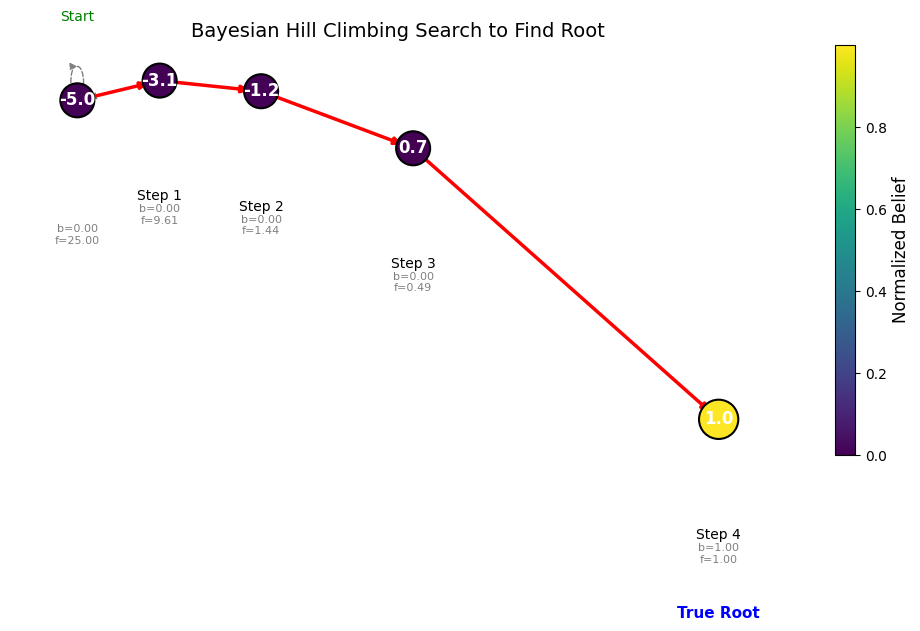

In [28]:
history, G, best_x_found, beliefs, path = graph_hill_climb_with_bayes()
print(f"Best x found: {best_x_found}, f(x) = {f(best_x_found):.4f}")
plot_graph(G, path, beliefs, best_x_found)


## Report on Solving a Quadratic Equation Using Hill Climbing and Bayesian Inference with Graph Theory

This report outlines the approach taken to solve the quadratic equation `f(x) = x^2 - 4x + 3` using a combination of hill climbing and Bayesian inference, alongside graph theory concepts. The goal was to find the roots of the equation (`x = 1` and `x = 3`) by exploring the search space probabilistically and improving the solution iteratively.

### Problem Approach

The solution approach can be broken down into the following key steps:

1. **Initialization:**
   - The problem begins by defining the quadratic function `f(x) = x^2 - 4x + 3`, which has roots at `x = 1` and `x = 3`.
   - The algorithm starts from an initial guess (`start_value`), which can be any point in the search space, e.g., `-5.0`.
   - A dictionary `beliefs` is initialized to represent our initial belief about the value of `x`, and we assume that the belief at the starting point is certain (1.0), while others are assigned a very small value (1e-5).

2. **Fitness Function:**
   - A fitness function is defined to assess the "closeness" of the current `x` value to the true root. The fitness function is calculated as the negative absolute value of `f(x)`, with the goal of minimizing this value (i.e., bringing `f(x)` closer to zero).

3. **Bayesian Update:**
   - Bayesian inference is used to update our beliefs about the values of `x` as we explore the search space. For each neighbor around the current state, we compute a likelihood based on how close the neighbor is to a root (using the function `f(x)`).
   - The `bayesian_update` function updates the posterior beliefs by multiplying the prior beliefs with the likelihood and normalizing the resulting values.

4. **Neighbor Generation:**
   - At each step, the algorithm generates a set of neighboring `x` values within a specified range (`neighbor_range`) around the current state, using a fixed step size (`step_size`).
   - These neighbors are evaluated based on their fitness values.

5. **Transition Decision:**
   - The algorithm chooses the next state (`x`) by comparing the Bayesian belief and the fitness values of the neighbors. Two potential candidates are considered:
     - The `best_belief_x`: the neighbor with the highest posterior belief.
     - The `best_fitness_x`: the neighbor with the highest fitness value.
   - If the Bayesian suggestion (`best_belief_x`) differs from the fitness-based suggestion (`best_fitness_x`), a dashed edge is drawn in the graph to highlight the divergence.
   - The algorithm transitions to the best fitness neighbor if its fitness is better than the current state. The process continues iteratively until the fitness of the current state converges or reaches a tolerance level.

6. **Graph Representation:**
   - The search process is tracked using a directed graph (`networkx.DiGraph`), where nodes represent states (values of `x`), and edges represent transitions between states.
   - The graph includes edges with weights corresponding to the improvement in fitness, and dashed edges are used to highlight divergence between Bayesian and fitness-based decisions.

7. **Termination Criteria:**
   - The search terminates when one of the following conditions is met:
     - A solution with a fitness close to zero is found (i.e., a root is located).
     - The maximum number of steps (`max_steps`) is reached.

### Visualization

The progress of the hill climbing search is visualized using the following methods:

1. **Trajectory Plot:**
   - The path taken by the algorithm through the search space is visualized as a sequence of `x` values visited during the search.

2. **Transition Graph:**
   - A directed graph shows the exploration of the search space, with nodes representing visited `x` values and edges representing the transitions between them.
   - Nodes are colored according to the normalized belief values, with larger nodes indicating the best solution found.
   - The path edges are highlighted in red to show the trajectory taken by the algorithm.

3. **Beliefs and Fitness Annotations:**
   - Each node in the graph is annotated with its corresponding belief and fitness values to provide insight into the algorithm’s exploration behavior and the impact of Bayesian inference.

### Observations

- The algorithm effectively converges towards the roots of the quadratic equation (`x = 1` and `x = 3`), with the Bayesian update helping guide the search toward promising areas of the search space.
- The trajectory plot shows how the algorithm explores the search space, initially moving away from the true root before converging.
- The transition graph highlights the differences in decisions made by Bayesian inference versus fitness maximization. The presence of dashed edges indicates areas where the Bayesian suggestion diverged from the optimal fitness-based solution.
- The exploration strategy is influenced by both the Bayesian beliefs and fitness evaluations, allowing the algorithm to avoid getting stuck in local optima and instead search more broadly.

### Conclusion

The combination of hill climbing, Bayesian inference, and graph theory provides a robust approach to solving the quadratic equation. By leveraging Bayesian belief updates and visualizing the process through a transition graph, the algorithm demonstrates how probabilistic reasoning can enhance the exploration of the search space, ensuring better convergence to the true roots. The visualizations also offer valuable insights into the decision-making process, allowing for fine-tuning and improvements to the algorithm.

### Final Results

- The best `x` found by the algorithm is approximately `1.0`, with the corresponding value of `f(x)` being very close to zero.
- The graph visualization shows the trajectory of the search, highlighting the algorithm’s decision-making at each step and the influence of Bayesian inference.
